In [4]:
import numpy as np
import pandas as pd
import os

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [5]:
merp_df = pd.DataFrame()

path = 'C:\\Users\\richi\\OneDrive\\Documents\\2021_UM_Hackathon\\BPAM Evaluated Prices Rated Range Prices (LT)'
for month in os.listdir(path):
    print(month)
    subpath = path+os.sep+month
    for files in os.listdir(subpath):
        if "MERP" in files:
            print(files) 
            data = pd.read_csv(subpath+os.sep+files)
            data['Year_Month'] = month
            print(data.shape)
            
            merp_df = merp_df.append(data,ignore_index=True)
            print(merp_df.shape)
            print("")

201907
BPAMERP20190731.csv
(2085, 20)
(2085, 20)

201908
BPAMERP20190830.csv
(2094, 20)
(4179, 20)

201909
BPAMERP20190930.csv
(2099, 20)
(6278, 20)

201910
BPAMERP20191031.csv
(2126, 20)
(8404, 20)

201911
BPAMERP20191129.csv
(2131, 20)
(10535, 20)

201912
BPAMERP20191231.csv
(2147, 20)
(12682, 20)

202001
BPAMERP20200131.csv
(2139, 20)
(14821, 20)

202002
BPAMERP20200228.csv
(2152, 20)
(16973, 20)

202003
BPAMERP20200331.csv
(2152, 20)
(19125, 20)

202004
BPAMERP20200430.csv
(2145, 20)
(21270, 20)

202005
BPAMERP20200529.csv
(2133, 20)
(23403, 20)

202006
BPAMERP20200630.csv
(2136, 20)
(25539, 20)

202007
BPAMERP20200730.csv
(2154, 20)
(27693, 20)

202008
BPAMERP20200828.csv
(2145, 20)
(29838, 20)

202009
BPAMERP20200930.csv
(2159, 20)
(31997, 20)

202010
BPAMERP20201030.csv
(2209, 20)
(34206, 20)



In [6]:
mers_df = pd.DataFrame()

path = 'C:\\Users\\richi\\OneDrive\\Documents\\2021_UM_Hackathon\\BPAM Evaluated Prices Rated Range Prices (LT)'
for month in os.listdir(path):
    print(month)
    subpath = path+os.sep+month
    for files in os.listdir(subpath):
        if "MERS" in files:
            print(files) 
            data = pd.read_csv(subpath+os.sep+files)
            data['Year_Month'] = month
            print(data.shape)
            
            mers_df = mers_df.append(data,ignore_index=True)
            print(mers_df.shape)
            print("")

201907
BPAMERS20190731.csv
(2085, 34)
(2085, 34)

201908
BPAMERS20190830.csv
(2094, 34)
(4179, 34)

201909
BPAMERS20190930.csv
(2099, 34)
(6278, 34)

201910
BPAMERS20191031.csv
(2126, 34)
(8404, 34)

201911
BPAMERS20191129.csv
(2131, 34)
(10535, 34)

201912
BPAMERS20191231.csv
(2147, 34)
(12682, 34)

202001
BPAMERS20200131.csv
(2139, 34)
(14821, 34)

202002
BPAMERS20200228.csv
(2152, 34)
(16973, 34)

202003
BPAMERS20200331.csv
(2152, 34)
(19125, 34)

202004
BPAMERS20200430.csv
(2145, 34)
(21270, 34)

202005
BPAMERS20200529.csv
(2133, 34)
(23403, 34)

202006
BPAMERS20200630.csv
(2136, 34)
(25539, 34)

202007
BPAMERS20200730.csv
(2154, 34)
(27693, 34)

202008
BPAMERS20200828.csv
(2145, 34)
(29838, 34)

202009
BPAMERS20200930.csv
(2159, 34)
(31997, 34)

202010
BPAMERS20201030.csv
(2209, 34)
(34206, 34)



In [7]:
print(merp_df.shape)
print(mers_df.shape)
df = merp_df.merge(mers_df,on=['STOCK CODE','Year_Month','ISIN CODE','STOCK NAME'],how='inner')
print(df.shape)

(34206, 20)
(34206, 34)
(34206, 50)


### Data Preparation

In [8]:
df2 = df[df['RATING'].str.contains("AA")].reset_index(drop=True)

In [9]:
for col in ['VALUE DATE','PREVIOUS PAYMENT DATE','ISSUE DATE','MATURITY DATE','NEXT PAYMENT DATE']:
    df2[col] = pd.to_datetime(df2[col])

In [10]:
df2['PREVIOUS PAYMENT DATE for calculation'] = df2['PREVIOUS PAYMENT DATE'].copy()
df2.loc[df2['PREVIOUS PAYMENT DATE for calculation'].isnull(),'PREVIOUS PAYMENT DATE for calculation']=df2.loc[df2['PREVIOUS PAYMENT DATE for calculation'].isnull()]['ISSUE DATE']

In [11]:
df2["Value-Prev"] = df2['VALUE DATE'] - df2['PREVIOUS PAYMENT DATE for calculation']
df2["Value-Prev"] = df2["Value-Prev"].astype(str).str.replace(" days","").astype(int)

In [12]:
df2.dropna(subset=['PREVIOUS PAYMENT DATE','NEXT PAYMENT DATE'],inplace=True)
df2["Payment Days diff"] = df2['NEXT PAYMENT DATE'] - df2['PREVIOUS PAYMENT DATE']
df2["Payment Days diff"] = df2["Payment Days diff"].astype(str).str.replace(" days","").astype(int)

In [13]:
df2['Year'] = df2['Year_Month'].str[:4].astype(int)
df2['Month'] = df2['Year_Month'].str[4:].astype(int)
df2['Day'] = 1

df2['Date'] = pd.to_datetime(df2[["Year","Month","Day"]])

In [14]:
thisdict = {
  "ACTACT": 1,
  "ACT365": 2,
  "ACTBOTH": 3
}

df2['DAY COUNT BASIS (INT)']= df2['DAY COUNT BASIS'].map(thisdict)
df2 = df2[df2['DAY COUNT BASIS (INT)']!=3]

In [15]:
nominal = 5000000

df2["ACCRUED INTEREST 1"] = nominal*(df2['NEXT COUPON RATE']/100)*(df2["Value-Prev"]/df2["Payment Days diff"])
df2["ACCRUED INTEREST 2"] = nominal*(df2['NEXT COUPON RATE']/100)*(df2["Value-Prev"]/365)

df2['ACCRUED INTEREST'] = df2["ACCRUED INTEREST 1"].copy()
df2.loc[df2['DAY COUNT BASIS (INT)']==2,'ACCRUED INTEREST'] = df2.loc[df2['DAY COUNT BASIS (INT)']==2]["ACCRUED INTEREST 2"]

In [16]:
df2["TERM OF MATURITY"]= (df2['MATURITY DATE'] - df2['VALUE DATE'])
df2["TERM OF MATURITY"] = df2["TERM OF MATURITY"].astype(str).str.replace(" days","").astype(int)
df2["TERM OF MATURITY"] = df2["TERM OF MATURITY"]/365

In [17]:
processed_df = pd.DataFrame()

for d in df2['Date'].unique():
    
    d_0 = datetime.strptime(str(d).replace("T00:00:00.000000000",""), '%Y-%m-%d')
    d_1 = d_0 - relativedelta(months=1) 
    
    data_1 = df2[df2['Date'] == d_1][['STOCK CODE','ISIN CODE','STOCK NAME','EVAL MID YIELD','EVAL MID PRICE','ACCRUED INTEREST',"TERM OF MATURITY",'MODIFIED DURATION','Date']]
    data_0 = df2[df2['Date'] == d_0][['STOCK CODE','ISIN CODE','STOCK NAME','EVAL MID PRICE','EVAL MID YIELD CHANGE','CONVEXITY']].rename(columns={'EVAL MID PRICE':'EVAL MID PRICE M1',
                                                                                                                                      'EVAL MID YIELD CHANGE':'EVAL MID YIELD CHANGE M1',
                                                                                                                                                  'CONVEXITY':'CONVEXITY M1'})
    
    if not data_1.empty:
        print("Previous One Month : ",str(d_1).replace(" 00:00:00",""),data_1.shape)
        print("Future One Month : ",str(d_0).replace(" 00:00:00",""),data_0.shape)
        
        data = data_1.merge(data_0,on=['STOCK CODE','ISIN CODE','STOCK NAME'])
        
        processed_df = processed_df.append(data,ignore_index=True)
    
    print("")


Previous One Month :  2019-07-01 (1386, 9)
Future One Month :  2019-08-01 (1381, 6)

Previous One Month :  2019-08-01 (1381, 9)
Future One Month :  2019-09-01 (1388, 6)

Previous One Month :  2019-09-01 (1388, 9)
Future One Month :  2019-10-01 (1369, 6)

Previous One Month :  2019-10-01 (1369, 9)
Future One Month :  2019-11-01 (1347, 6)

Previous One Month :  2019-11-01 (1347, 9)
Future One Month :  2019-12-01 (1356, 6)

Previous One Month :  2019-12-01 (1356, 9)
Future One Month :  2020-01-01 (1372, 6)

Previous One Month :  2020-01-01 (1372, 9)
Future One Month :  2020-02-01 (1391, 6)

Previous One Month :  2020-02-01 (1391, 9)
Future One Month :  2020-03-01 (1390, 6)

Previous One Month :  2020-03-01 (1390, 9)
Future One Month :  2020-04-01 (1406, 6)

Previous One Month :  2020-04-01 (1406, 9)
Future One Month :  2020-05-01 (1417, 6)

Previous One Month :  2020-05-01 (1417, 9)
Future One Month :  2020-06-01 (1446, 6)

Previous One Month :  2020-06-01 (1446, 9)
Future One Month :  2

In [18]:
processed_df.dropna(subset=['EVAL MID YIELD',
       'EVAL MID PRICE', 'ACCRUED INTEREST', 'TERM OF MATURITY',
       'MODIFIED DURATION', 'Date', 'EVAL MID PRICE M1'],how='any',inplace=True)

In [19]:
no_sep_oct =processed_df[~processed_df['Date'].between('2020-09-01', '2020-10-01')]
sep_oct= processed_df[processed_df['Date'].between('2020-09-01','2020-10-01')]

### Define Features and Label

In [20]:
X_col = ['EVAL MID YIELD','EVAL MID PRICE','ACCRUED INTEREST',"TERM OF MATURITY",'MODIFIED DURATION']
y_col = 'EVAL MID PRICE M1'
X = no_sep_oct[X_col]
y = no_sep_oct[y_col]

#### Train set, Test set, Validation set

In [21]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [22]:
print('Training X Shape:', train_X.shape)
print('Training y Shape:', test_X.shape)
print('Testing X Shape:', train_y.shape)
print('Testing y Shape:', test_y.shape)

Training X Shape: (14461, 5)
Training y Shape: (4821, 5)
Testing X Shape: (14461,)
Testing y Shape: (4821,)


#### Non parameteric model - Random Forest

In [45]:
### Grid Search to tune hyperparameter for random forest
param_grid = {
    'n_estimators' : [50,60,65,70,75,80,85,90,100],
    'max_depth' : [5,6,7,8,9,10,11,12]
}

### Grid Search
RF=GridSearchCV(RandomForestRegressor(random_state=10), param_grid, cv=2,n_jobs=3)
RF.fit(train_X, train_y)

best_params=RF.best_params_
        
max_depth=best_params["max_depth"]
n_estimators=best_params["n_estimators"]
        
rf=RandomForestRegressor(random_state=10,n_estimators=n_estimators,max_depth=max_depth)
rf.fit(train_X, train_y)

# Use the forest's predict method on the test data
predictions = rf.predict(test_X)
newpred= rf.predict(sep_oct[X_col])

# Calculate the absolute errors
errors = abs(predictions - test_y)
newerrors = abs(newpred - sep_oct[y_col])

print("Random Forest: ")
print("")

# Print out the mean absolute error (mae)
print('Mean Absolute Error Test:', round(np.mean(errors), 2))
print('Mean Absolute Error Sep, Oct:', round(np.mean(newerrors), 2))
print("")

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
newmape = 100 * (newerrors / sep_oct[y_col])

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
accuracy_Sep_oct = 100 - np.mean(newmape)
print('Accuracy test:', round(accuracy, 2), '%.')
print('Accuracy Sep,Oct:', round(accuracy_Sep_oct, 2), '%.')
print("")

r_sq = r2_score(test_y, predictions)
r_sq2 = r2_score(sep_oct[y_col], newpred)
print('coefficient of determination:', np.round(r_sq,2))
print('coefficient of determination Sep,Oct:', np.round(r_sq2,2))

Random Forest: 

Mean Absolute Error Test: 0.8
Mean Absolute Error Sep, Oct: 0.45

Accuracy test: 99.27 %.
Accuracy Sep,Oct: 99.6 %.

coefficient of determination: 0.94
coefficient of determination Sep,Oct: 0.98


#### Parameteric model - Multi Linear Regression

In [48]:
model = LinearRegression()

model.fit(train_X, train_y)

predictions = model.predict(test_X)
newpred= model.predict(sep_oct[X_col])

# Calculate the absolute errors
errors = abs(predictions - test_y)
newerrors = abs(newpred - sep_oct[y_col])

print("Linear Regression: ")
print("")

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error Sep, Oct:', round(np.mean(newerrors), 2))
print("")

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
newmape = 100 * (newerrors / sep_oct[y_col])

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
accuracy_Sep_oct = 100 - np.mean(newmape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Accuracy Sep,Oct:', round(accuracy_Sep_oct, 2), '%.')
print("")

r_sq = r2_score(test_y, predictions)
r_sq2 = r2_score(sep_oct[y_col], newpred)
print('coefficient of determination:', np.round(r_sq,2))
print('coefficient of determination Sep,Oct:', np.round(r_sq2,2))

Linear Regression: 

Mean Absolute Error: 0.86
Mean Absolute Error Sep, Oct: 0.39

Accuracy: 99.21 %.
Accuracy Sep,Oct: 99.65 %.

coefficient of determination: 0.93
coefficient of determination Sep,Oct: 0.99


In [46]:
sep_oct['EVAL MID PRICE PREDICTION M1']= model.predict(sep_oct[X_col])
sep_oct[['STOCK CODE','ISIN CODE','STOCK NAME','EVAL MID PRICE','EVAL MID PRICE PREDICTION M1','EVAL MID PRICE M1']]

<ipython-input-46-50edc44a5942>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_oct['EVAL MID PRICE PREDICTION M1']= model.predict(sep_oct[X_col])


,STOCK CODE,ISIN CODE,STOCK NAME,EVAL MID PRICE,EVAL MID PRICE PREDICTION M1,EVAL MID PRICE M1
19282,DZ012851,MYBDZ0128511,TENAGA IBONDS 0.00000% 13.12.2021,105.784,105.136686,105.499
19283,DZ021250,MYBDZ0212505,GDC PUTRA 0.00000% 02.12.2022,110.094,109.450615,109.892
19284,VQ080767,MYBVQ0807677,JEV IMTN 0% 12.11.2020,100.776,100.766402,100.187
19285,VR061774,MYBVR0617744,JEV IMTN 0% 12.11.2020,100.747,100.730090,100.181
19286,VS060699,MYBVS0606992,JEV IMTN 0% 12.11.2020,100.731,100.709596,100.177
...,...,...,...,...,...,...
20681,PK200003,MYBPK2000037,AEON CREDIT SENIOR SUKUK (SERIES 1 TRANCHE 1),102.676,103.170374,102.819
20682,PL200002,MYBPL2000027,AEON CREDIT SENIOR SUKUK (SERIES 1 TRANCHE 2),102.891,103.491778,103.075
20683,PZ200004,MYBPZ2000043,TG EXCELLENCE SUKUK WAKALAH (TRANCHE 1),103.810,103.943683,103.680
20684,VH200018,MYBVH2000189,EXSIM VEN IMTN 4.700% 28.08.2023,101.523,101.928715,101.508


### Post Model Feature Analysis

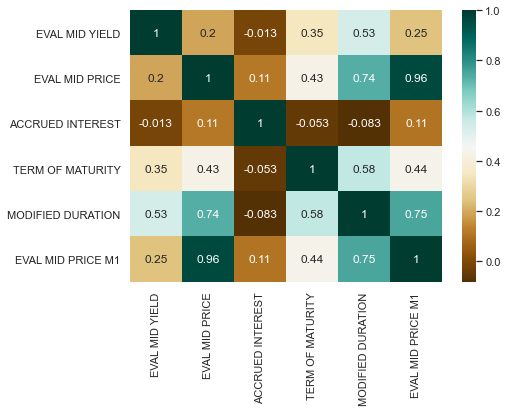

In [25]:
# Finding the relations between the variables.
plt.figure(figsize=(7,5))
c= processed_df[X_col+[y_col]].corr()
sns.heatmap(c,cmap="BrBG",annot=True)
plt.show()

### Stage 1 : Bond Price Prediction
#### Bond Prediction for Value Date = 2020-11-02

In [26]:
bond_price_beg_end = df2.groupby(['STOCK CODE']).agg({"Date":"min"}).reset_index()
bond_price_beg_end.rename(columns={"Date":"DATE BEG"},inplace=True)

print(bond_price_beg_end.shape)
bond_price_beg_end = bond_price_beg_end.merge(df2[['STOCK CODE','Date','EVAL MID PRICE']].rename(columns={"Date":"DATE BEG",
                                                                                                         "EVAL MID PRICE":"EVAL MID PRICE BEG"}),on=["STOCK CODE","DATE BEG"])
print(bond_price_beg_end.shape)

(1648, 2)
(1648, 3)


In [27]:
BondReturn_Col = ['COUPON FREQUENCY','REMAINING TENURE','EVAL MID YIELD CHANGE','CONVEXITY']

nov_forecast = df2[df2['VALUE DATE']=="2020-11-02"].reset_index(drop=True)
nov_forecast = nov_forecast[['STOCK CODE','ISIN CODE','STOCK NAME','VALUE DATE']+X_col+BondReturn_Col]

nov_forecast['REMAINING TENURE M/Y'] = nov_forecast['REMAINING TENURE'].apply(lambda x: x[-1] if x[-1]!="+" else x[-2:])
nov_forecast['REMAINING TENURE Integer'] = nov_forecast['REMAINING TENURE'].apply(lambda x: x[:-1] if x[-1]!="+" else x[:-2]).astype(int)
nov_forecast['MD'] = nov_forecast[['REMAINING TENURE M/Y','REMAINING TENURE Integer']].apply(lambda x:x[1] if x[0]=='M' else x[1]*12,axis=1)

print(nov_forecast.shape)
nov_forecast = nov_forecast.merge(bond_price_beg_end,on=['STOCK CODE'])
print(nov_forecast.shape)

(1409, 16)
(1409, 18)


### Stage 2 : Calculate Bond Return and Volatility
##### To calculate Bond Return based on Nov'20 Bond Price Prediction

In [28]:
nov_forecast['NOV20 BOND PRICE'] = model.predict(nov_forecast[X_col])
nov_forecast['NOV20 YIELD INCOME'] = nov_forecast['NOV20 BOND PRICE']/nov_forecast['COUPON FREQUENCY']
nov_forecast['NOV20 ROLL DOWN RETURN'] = (nov_forecast['NOV20 BOND PRICE'] - nov_forecast['EVAL MID PRICE BEG'])/nov_forecast['EVAL MID PRICE BEG']
nov_forecast['OCT20 EXPECTED CHG IN YIELD'] = (-nov_forecast['MD']*nov_forecast['EVAL MID YIELD CHANGE'])+(0.5*nov_forecast['CONVEXITY']*nov_forecast['EVAL MID YIELD CHANGE']*nov_forecast['EVAL MID YIELD CHANGE'])

nov_forecast['NOV20 BOND RETURN'] = nov_forecast[['NOV20 YIELD INCOME','NOV20 ROLL DOWN RETURN','OCT20 EXPECTED CHG IN YIELD']].sum(1)

##### To calculate Volatility, calculate standard deviation of each bond

In [40]:
df_nov = nov_forecast[['STOCK CODE','NOV20 BOND PRICE']]
df_nov['Date'] = pd.to_datetime("2020-11-01")
df_nov.rename(columns={"NOV20 BOND PRICE":"EVAL MID PRICE"},inplace=True)

vol_df = df2[['STOCK CODE','Date','EVAL MID PRICE']].reset_index(drop=True)
vol_df = vol_df.append(df_nov[['STOCK CODE','Date','EVAL MID PRICE']].reset_index(drop=True),ignore_index=True)

vol_df = vol_df.groupby(['STOCK CODE']).agg({"EVAL MID PRICE":np.nanstd}).reset_index()
vol_df.rename(columns={"EVAL MID PRICE":"EVAL MID PRICE STD DEV"},inplace=True)

<ipython-input-40-6d28a8fa0a92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nov['Date'] = pd.to_datetime("2020-11-01")
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [30]:
print(nov_forecast.shape)
nov_forecast = nov_forecast.merge(vol_df,on=['STOCK CODE'])
print(nov_forecast.shape)

(1409, 23)
(1409, 24)


In [31]:
nov_forecast['NOV20 BOND VOLATILITY'] = nov_forecast['EVAL MID PRICE STD DEV'] * np.sqrt(252)
nov_forecast['NOV20 RETURN/VOLATILITY'] = nov_forecast['NOV20 BOND RETURN']/nov_forecast['NOV20 BOND VOLATILITY']

In [32]:
nov_forecast[['NOV20 BOND RETURN','NOV20 BOND VOLATILITY','NOV20 RETURN/VOLATILITY']].describe()

,NOV20 BOND RETURN,NOV20 BOND VOLATILITY,NOV20 RETURN/VOLATILITY
count,1409.000000,1409.000000,1409.000000
mean,54.031853,22.913697,6.211094
std,4.778330,15.946499,27.470337
min,10.077039,0.071130,0.206477
25%,51.580024,8.644109,1.556097
50%,53.436306,20.191404,2.656698
75%,55.996258,36.017944,6.012023
max,105.929854,84.371069,724.934082


### Stage 3 : Choose Top 5 Bond based on Bond Return over Bond Volatility

In [33]:
nov_forecast.sort_values(["NOV20 RETURN/VOLATILITY"],ascending=False)[['STOCK CODE','ISIN CODE','STOCK NAME','VALUE DATE',
                                                                       'NOV20 BOND PRICE', 
                                                                       'NOV20 YIELD INCOME', 
                                                                       'NOV20 ROLL DOWN RETURN',
                                                                       'OCT20 EXPECTED CHG IN YIELD', 
                                                                       'NOV20 BOND RETURN',
                                                                       'NOV20 BOND VOLATILITY',
                                                                       'NOV20 RETURN/VOLATILITY']].head()

,STOCK CODE,ISIN CODE,STOCK NAME,VALUE DATE,NOV20 BOND PRICE,NOV20 YIELD INCOME,NOV20 ROLL DOWN RETURN,OCT20 EXPECTED CHG IN YIELD,NOV20 BOND RETURN,NOV20 BOND VOLATILITY,NOV20 RETURN/VOLATILITY
100,UI200090,MYBUI2000908,CIMB MTN 1826D 03.4.2025 - Issue No 8,2020-11-02,103.129337,51.564668,0.000061,0.000000,51.564730,0.071130,724.934082
472,VE200066,MYBVE2000665,UEMS IMTN 3.70% 03.05.2021 - Issue No. 8,2020-11-02,100.196005,50.098002,-0.000070,0.006000,50.103933,0.078521,638.098457
257,UI200083,MYBUI2000833,SCSB SENIOR CLASS A MTNS (SERIES 4),2020-11-02,102.508600,51.254300,0.000201,0.000000,51.254501,0.231230,221.660191
940,VI200059,MYBVI2000591,COUNTRY GDN IMTN 5.250% 27.03.2025- Issue No 7,2020-11-02,107.105719,53.552860,0.000259,0.060009,53.613128,0.242552,221.037836
941,VK200019,MYBVK2000191,COUNTRY GDN IMTN 5.700% 02.03.2027 - Issue No 5,2020-11-02,110.923833,55.461917,0.000540,0.000000,55.462456,0.531685,104.314518
